In [1]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import seaborn as sns
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import keras
import json
import sys
import tensorflow as tf
from keras.layers import Input
import argparse
from keras.utils.data_utils import get_file
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense, Lambda
from keras.layers import Input, Flatten
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


<annotation>
	<folder></folder>
	<filename>56_Voter_peoplevoting_56_922_jpg.rf.3297d86f605e108a40609060e30a34b3.jpg</filename>
	<path>56_Voter_peoplevoting_56_922_jpg.rf.3297d86f605e108a40609060e30a34b3.jpg</path>
	<source>
		<database>roboflow.ai</database>
	</source>
	<size>
		<width>1024</width>
		<height>1366</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>face</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>246</xmin>
			<xmax>745</xmax>
			<ymin>327</ymin>
			<ymax>1069</ymax>
		</bndbox>
	</object>
</annotation>

[246, 327, 745, 1069]


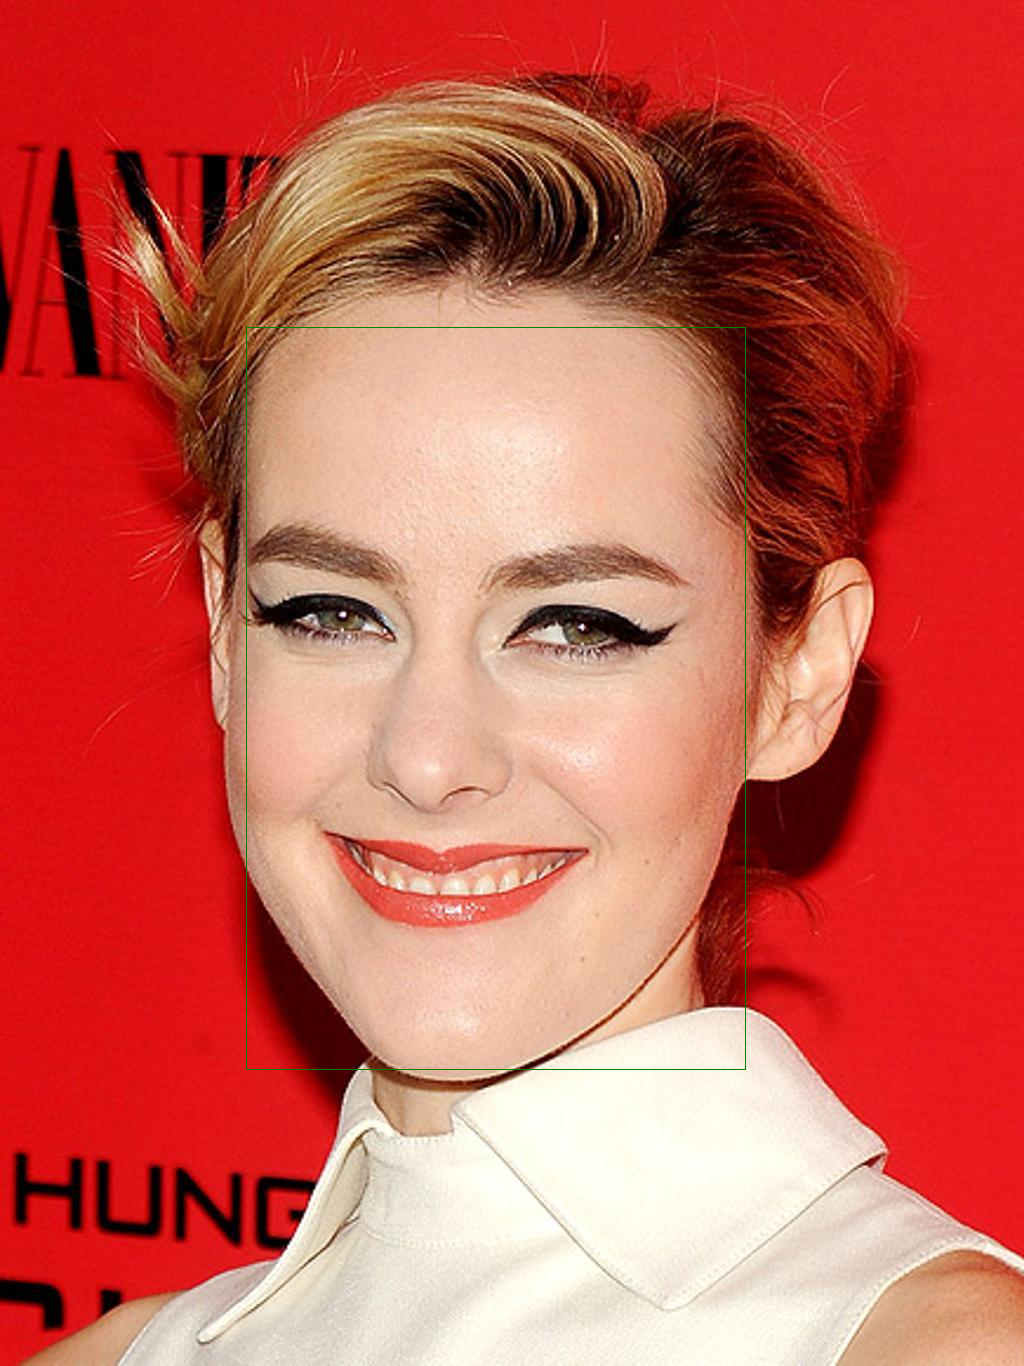

In [3]:
sample_image = Image.open('./faces/train/56_Voter_peoplevoting_56_922_jpg.rf.3297d86f605e108a40609060e30a34b3.jpg')

with open('./faces/train/56_Voter_peoplevoting_56_922_jpg.rf.3297d86f605e108a40609060e30a34b3.xml') as annot_file:
    print(''.join(annot_file.readlines()))
tree = ET.parse('./faces/train/56_Voter_peoplevoting_56_922_jpg.rf.3297d86f605e108a40609060e30a34b3.xml')
root = tree.getroot()

sample_annotations = []

for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)

    sample_annotations.append([xmin, ymin, xmax, ymax])

sample_image_annotated = sample_image.copy()
img_bbox = ImageDraw.Draw(sample_image_annotated)
for bbox in sample_annotations:
    print(bbox)
    img_bbox.rectangle(bbox, outline="green")

sample_image_annotated

### Firstly, load the images

In [4]:
def load_dataset(path):
    images = []
    bounding_boxes = []
    result = []
    for i in os.listdir(path):
        if i[-3:] == 'xml':
            tree = ET.parse(path + i)
            root = tree.getroot()
            annotation = []
            for neighbor in root.iter('bndbox'):
                xmin = int(neighbor.find('xmin').text)
                ymin = int(neighbor.find('ymin').text)
                xmax = int(neighbor.find('xmax').text)
                ymax = int(neighbor.find('ymax').text)
                annotation.append([xmin, ymin, xmax, ymax])
            if len(annotation) == 0:
                continue
                bounding_boxes.append([0,0,0,0])
                result.append(to_categorical(0, 2))
                sample_image = np.asarray(Image.open(path + i[:-3] + 'jpg'))
                # sample_image = np.resize(sample_image, (224,224,3))
                images.append(sample_image)
            else:
                bounding_boxes.append([xmin, ymin, xmax, ymax])
                result.append(to_categorical(1, 2))
                sample_image = np.asarray(Image.open(path + i[:-3] + 'jpg'))
                # sample_image = np.resize(sample_image, (224,224,3))
                images.append(sample_image)
    return images, bounding_boxes, result

In [5]:
train_images, train_boxes, train_result = load_dataset(path = "./faces/train/")
val_images, val_boxes, val_result = load_dataset(path="./faces/valid/")
test_images, test_boxes, test_result = load_dataset(path="./faces/test/")


In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

Create the two branch model

In [126]:
class MultiOutputModel():

    def make_hidden_layers(self, inputs):
        x = vgg(inputs)
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        # x = Dropout(0.25)(x)
        # x = Conv2D(64, (3, 3), padding="same")(x)
        # x = Activation("relu")(x)
        # x = BatchNormalization(axis=-1)(x)
        # x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.25)(x)
        # x = Conv2D(64, (3, 3), padding="same")(x)
        # x = Activation("relu")(x)
        # x = BatchNormalization(axis=-1)(x)
        # x = MaxPooling2D(pool_size=(2, 2))(x)
        return x
    def boundingbox_branch(self, inputs):
        x = self.make_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        # x = Dense(64)(x)
        # x = Activation("relu")(x)
        # x = BatchNormalization()(x)
        # x = Dense(32)(x)
        # x = Activation("relu")(x)
        # x = BatchNormalization()(x)
        # x = Dense(16)(x)
        # x = Activation("relu")(x)
        # x = BatchNormalization()(x)
        x = Dense(4)(x)
        x = Activation("sigmoid", name="bb_output")(x)
        # x = Activation("relu", name="bb_output")(x)
        return x
    def face_branch(self, inputs):
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.make_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        # x = Dropout(0.5)(x)
        x = Dense(2)(x)
        x = Activation("softmax", name="face_output")(x)
        # x = tf.abs(x)
        return x

    def assemble_full_model(self, width, height):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        boundingbox_branch = self.boundingbox_branch(inputs)
        face_branch = self.face_branch(inputs)
        model = Model(inputs=inputs,
                      outputs = [boundingbox_branch, face_branch],
                      name="face_detector")
        return model


In [127]:
model = MultiOutputModel().assemble_full_model(224, 224)

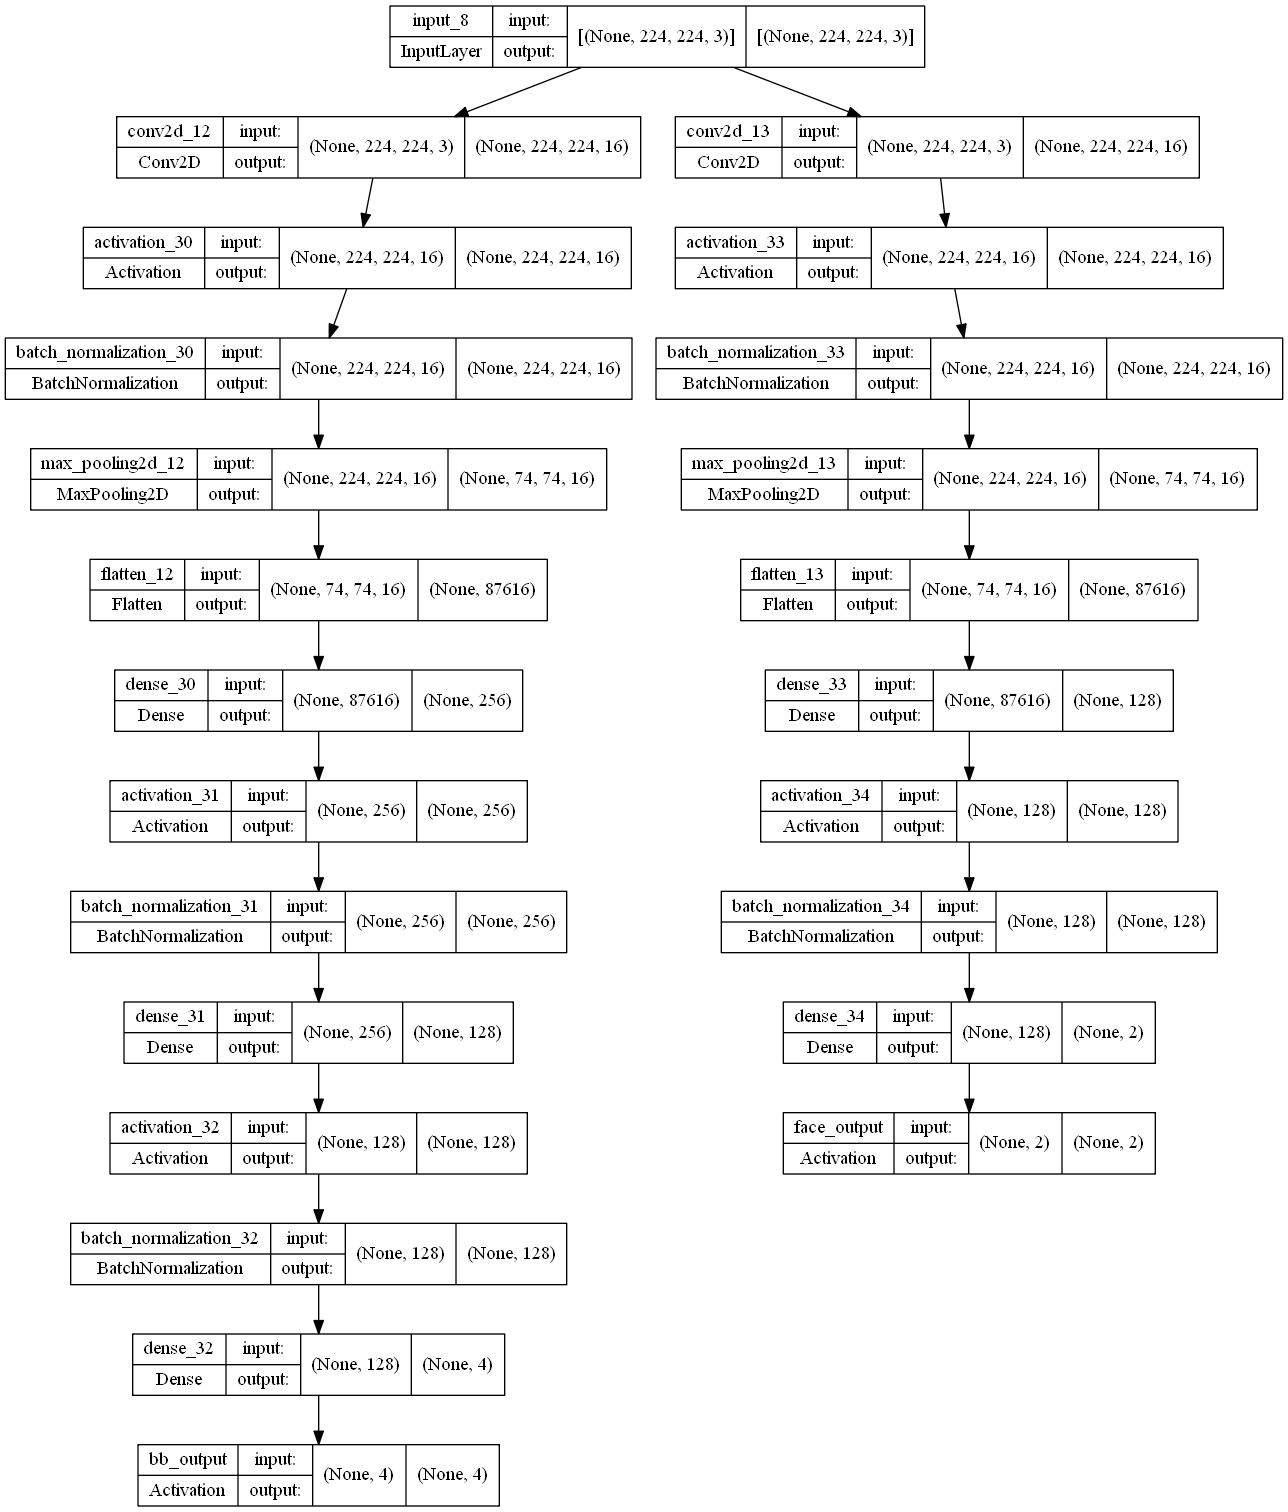

In [128]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [129]:
def data_generator(list_index, check, batch_size, bounding_boxes_array, faces_array, resized_images_array):
    images, bbs, faces = [], [], []
    while True:
        for idx in list_index:
            bb = bounding_boxes_array[idx]
            face = faces_array[idx]
            image = resized_images_array[idx]
            width = image.shape[1]
            height = image.shape[0]
            bb[0] = bb[0]/width
            bb[2] = bb[2]/width
            bb[1] = bb[1]/height
            bb[3] = bb[3]/height
            image = np.resize(image, (224,224,3))/255
            bbs.append(bb)
            faces.append(face)
            images.append(image)

            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(bbs), np.array(faces)]
                images, bbs, faces = [], [], []
        if not check:
            break

In [130]:
random_train_indexes = np.random.permutation(len(train_boxes))
random_valid_indexes = np.random.permutation(len(val_boxes))
random_test_indexes = np.random.permutation(len(test_boxes))

In [131]:
train_generator = data_generator(random_train_indexes, check=True, batch_size=16, bounding_boxes_array=train_boxes, faces_array=train_result, resized_images_array=train_images)
valid_generator = data_generator(random_valid_indexes, check=True, batch_size=16, bounding_boxes_array=val_boxes, faces_array=val_result, resized_images_array=val_images)
test_generator = data_generator(random_test_indexes, check=True, batch_size=16, bounding_boxes_array=test_boxes, faces_array=test_result, resized_images_array=test_images)
batch_size = 4
valid_batch_size = 4

In [140]:
learning_rate = 1e-4
epochs = 10
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(optimizer=opt,
              loss={
                  'bb_output': 'mse',
                  'face_output': 'binary_crossentropy'},
              # loss_weights={
              #     'bb_output': 1,
              #     'face_output': 1.5},
              metrics={
                  'bb_output': 'mae',
                  'face_output': 'accuracy'})

C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [141]:
callbacks = [
    ModelCheckpoint("./checkpoints", monitor='val_loss')
]
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(random_train_indexes)//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=valid_generator,
                              validation_steps=len(random_valid_indexes)//valid_batch_size)

Epoch 1/10


C:\Users\Felix\AppData\Local\Temp\ipykernel_19916\1669297015.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 [==============================] - 6s 239ms/step - loss: 0.8368 - bb_output_loss: 0.1849 - face_output_loss: 0.6520 - bb_output_mae: 0.3693 - face_output_accuracy: 0.7031 - val_loss: 0.7422 - val_bb_output_loss: 0.1994 - val_face_output_loss: 0.5427 - val_bb_output_mae: 0.4166 - val_face_output_accuracy: 0.9062
Epoch 2/10
20/20 [==============================] - 3s 170ms/step - loss: 0.8029 - bb_output_loss: 0.1739 - face_output_loss: 0.6290 - bb_output_mae: 0.3520 - face_output_accuracy: 0.8906 - val_loss: 0.6828 - val_bb_output_loss: 0.1737 - val_face_output_loss: 0.5091 - val_bb_output_mae: 0.3810 - val_face_output_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 4s 191ms/step - loss: 0.7763 - bb_output_loss: 0.1596 - face_output_loss: 0.6167 - bb_output_mae: 0.3357 - face_output_accuracy: 0.9719 - val_loss: 0.6522 - val_bb_output_loss: 0.1597 - val_face_output_loss: 0.4925 - val_bb_output_mae: 0.3560 - val_face_output_accuracy: 1.0000
Epoch 4/10
20/20 [===

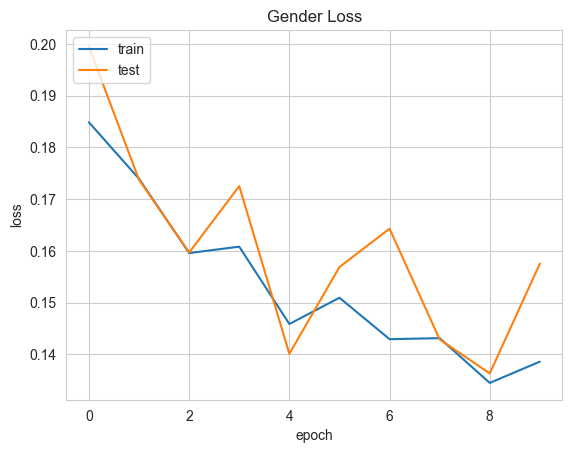

In [146]:
plt.plot(history.history['bb_output_loss'])
plt.plot(history.history['val_bb_output_loss'])
plt.title('bounding box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

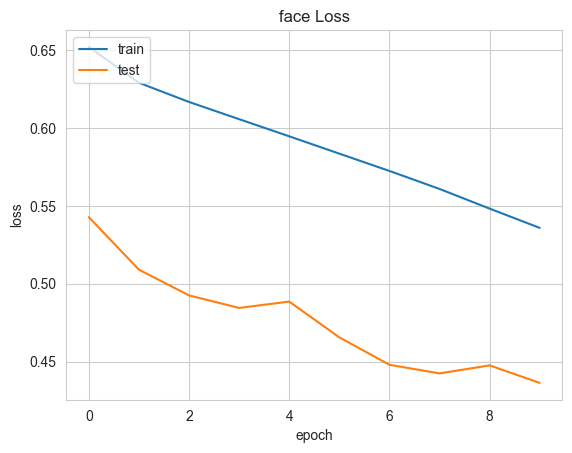

In [148]:
plt.plot(history.history['face_output_loss'])
plt.plot(history.history['val_face_output_loss'])
plt.title('face Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

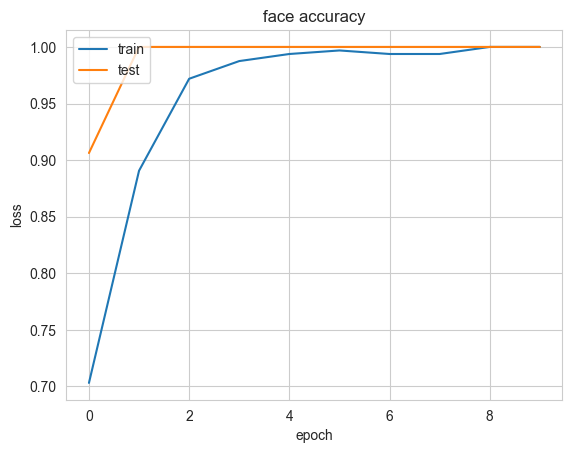

In [149]:
plt.plot(history.history['face_output_accuracy'])
plt.plot(history.history['val_face_output_accuracy'])
plt.title('face accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()